**План:**

Нам надо определить, чем отличаются пользователи, у которых несколько сим-карт, от пользователей с одного картой. На основе этого потом будет необходимо составить список номеров, потенциально принадлежащих одному человеку. Алгоритм в общем виде следующий:

   1. Строим из точек пути, рисуем их на карте, считаем попарные дистанции. Симки с одинаковыми дистанциями с большей вероятностью принадлежат одному человеку.
   2. Генерим доп фичи: расстояние, средняя скорость, марка смартфонов
    

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns

In [4]:
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df1 = pd.read_csv('Megafon/files/03_device.csv', sep = ',')
df2 = pd.read_csv('Megafon/files/02_Data.csv', sep = ';')
df3 = pd.read_excel('Megafon/files/01_facts.xlsx', header = None)
df3.columns = ['num_1', 'num_2']

In [5]:
df3.head()

,num_1,num_2
0,158530067653,158528861653
1,158510912201,158528852857
2,158530063945,158528861599
3,158524011325,158524011355
4,158528852153,158528861475


In [4]:
df3.num_1.unique().shape

(121,)

In [25]:
df2.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle,imei_8
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0,35311105
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0,1292900
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0,35199404
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0,35862701
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0,35245805


In [245]:
df2.shape

(174123, 13)

In [8]:
df1.tail()

,tac,vendor,platform,type
73258,86139301,KPT,Proprietary,Phone
73259,86861900,KPT,Proprietary,Phone
73260,86180601,KPT,Proprietary,Phone
73261,35440005,Google,Android,Laptop
73262,35413605,Nokia,Proprietary,Phone


In [6]:
df1.shape

(73263, 4)

### Слияние таблиц

In [6]:
df2['imei_8'] = df2.imei.apply(lambda x: str(x)[:8] if len(str(x)) == 17 else str(x)[:7])#вырезаем первые 8 символов для перeсечения с так

In [7]:
df1.tac = df1.tac.astype(str)

In [8]:
#мерджим координаты с марками телефонов
df4 = df2.merge(df1, how = 'left', right_on = 'tac', left_on = 'imei_8')

In [13]:
df4

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle,imei_8,tac,vendor,platform,type
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0,35311105,35311105,LG,Android,SmartPhone
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0,1292900,1292900,Apple,iOS,Laptop
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0,35199404,35199404,Nokia,ISA,Phone
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0,35862701,35862701,Nokia,ISA,Phone
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0,35245805,35245805,Samsung,Proprietary,Phone
5,5009,54219,158528782737,3.559431e+14,2,1369252804268,38.4582,55.3027,2346,OUTDOOR,270.0,330.0,35594305,NaN,NaN,NaN,NaN
6,7736,170,158534117157,1.303300e+13,0,1369252805348,37.5660,55.7445,100,OUTDOOR,315.0,45.0,1303300,1303300,Apple,iOS,SmartPhone
7,5029,7218,158526745515,3.562010e+14,0,1369252805960,37.9052,55.7793,521,OUTDOOR,26.5,73.5,35620104,35620104,Blackberry,BlackBerry OS,SmartPhone
8,7758,30597,158598231571,3.559420e+14,5,1369252808556,37.8153,55.6427,1205,OUTDOOR,145.0,205.0,35594204,35594204,Nokia,ISA,Phone
9,5030,16491,158528444553,3.568570e+14,0,1369252808619,37.8095,55.9318,500,OUTDOOR,330.0,30.0,35685702,35685702,Nokia,ISA,Phone


In [9]:
#переворачиваем известные номера, чтоб была связь в обе стороны
df31 = df3[['num_2', 'num_1']]
df31.columns = ['num_1', 'num_2']

In [12]:
df31.head()

,num_1,num_2
0,158528861653,158530067653
1,158528852857,158510912201
2,158528861599,158530063945
3,158524011355,158524011325
4,158528861475,158528852153


In [10]:
df_reverse = pd.concat([df3,df31], ignore_index=True)

In [11]:
df_reverse[df_reverse.num_2 == 158530067653]

,num_1,num_2
122,158528861653,158530067653


In [12]:
#мерджим координаты с марками с таргетом (известными дублями номеров)
df5 = df4.merge(df_reverse, how = 'left', right_on = 'num_1', left_on = 'msisdn')
df5

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle,imei_8,tac,vendor,platform,type,num_1,num_2
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0,35311105,35311105,LG,Android,SmartPhone,NaN,NaN
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0,1292900,1292900,Apple,iOS,Laptop,NaN,NaN
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0,35199404,35199404,Nokia,ISA,Phone,NaN,NaN
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0,35862701,35862701,Nokia,ISA,Phone,NaN,NaN
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0,35245805,35245805,Samsung,Proprietary,Phone,NaN,NaN
5,5009,54219,158528782737,3.559431e+14,2,1369252804268,38.4582,55.3027,2346,OUTDOOR,270.0,330.0,35594305,NaN,NaN,NaN,NaN,NaN,NaN
6,7736,170,158534117157,1.303300e+13,0,1369252805348,37.5660,55.7445,100,OUTDOOR,315.0,45.0,1303300,1303300,Apple,iOS,SmartPhone,NaN,NaN
7,5029,7218,158526745515,3.562010e+14,0,1369252805960,37.9052,55.7793,521,OUTDOOR,26.5,73.5,35620104,35620104,Blackberry,BlackBerry OS,SmartPhone,NaN,NaN
8,7758,30597,158598231571,3.559420e+14,5,1369252808556,37.8153,55.6427,1205,OUTDOOR,145.0,205.0,35594204,35594204,Nokia,ISA,Phone,NaN,NaN
9,5030,16491,158528444553,3.568570e+14,0,1369252808619,37.8095,55.9318,500,OUTDOOR,330.0,30.0,35685702,35685702,Nokia,ISA,Phone,NaN,NaN


In [15]:
df5.num_1.unique().shape

(242,)

In [16]:
df5.num_1.isnull().sum()

165910

In [25]:
df5.num_1.notnull().sum()

8581

Видим значительный перекос трейна и теста

### Geopandas

In [13]:
geometry = [Point(xy) for xy in zip(df5.long, df5.lat)]

In [14]:
df5['geometry'] = geometry

In [15]:
crs = {'init': 'epsg:4326'}
df_geo = gpd.GeoDataFrame(df5, crs=crs, geometry=geometry)

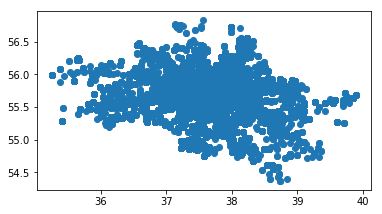

In [16]:
df_geo.plot()

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

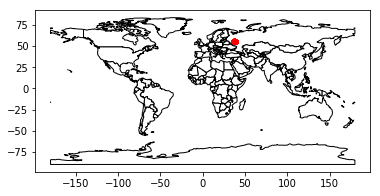

In [31]:
base = world.plot(color='white', edgecolor='black')

df_geo.plot(ax=base, marker='o', color='red', markersize=5);

Видимо, данные по Москве. Спарсим карты с OSM

In [32]:
mos_ref = gpd.read_file('moscow_reg.geojson')

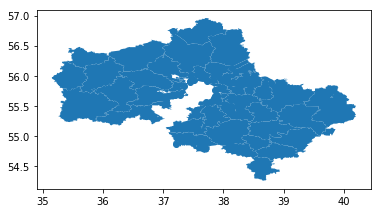

In [33]:
mos_ref.plot()

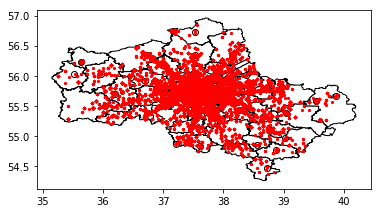

In [34]:
base = mos_ref.plot(color='white', edgecolor='black')

df_geo.plot(ax=base, marker='o', color='red', markersize=5);

In [35]:
mos = gpd.read_file('moscow.geojson')

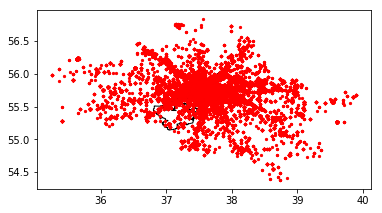

In [36]:
base = mos.plot(color='white', edgecolor='black')

df_geo.plot(ax=base, marker='o', color='red', markersize=5);

In [37]:
df_geo

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle,imei_8,tac,vendor,platform,type,num_1,num_2,geometry
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0,35311105,35311105,LG,Android,SmartPhone,NaN,NaN,POINT (37.9305 55.7815)
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0,1292900,1292900,Apple,iOS,Laptop,NaN,NaN,POINT (37.4239 55.7426)
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0,35199404,35199404,Nokia,ISA,Phone,NaN,NaN,POINT (37.7034 55.5803)
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0,35862701,35862701,Nokia,ISA,Phone,NaN,NaN,POINT (37.7895 55.7042)
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0,35245805,35245805,Samsung,Proprietary,Phone,NaN,NaN,POINT (37.19 55.8308)
5,5009,54219,158528782737,3.559431e+14,2,1369252804268,38.4582,55.3027,2346,OUTDOOR,270.0,330.0,35594305,NaN,NaN,NaN,NaN,NaN,NaN,POINT (38.4582 55.3027)
6,7736,170,158534117157,1.303300e+13,0,1369252805348,37.5660,55.7445,100,OUTDOOR,315.0,45.0,1303300,1303300,Apple,iOS,SmartPhone,NaN,NaN,POINT (37.566 55.7445)
7,5029,7218,158526745515,3.562010e+14,0,1369252805960,37.9052,55.7793,521,OUTDOOR,26.5,73.5,35620104,35620104,Blackberry,BlackBerry OS,SmartPhone,NaN,NaN,POINT (37.9052 55.7793)
8,7758,30597,158598231571,3.559420e+14,5,1369252808556,37.8153,55.6427,1205,OUTDOOR,145.0,205.0,35594204,35594204,Nokia,ISA,Phone,NaN,NaN,POINT (37.8153 55.6427)
9,5030,16491,158528444553,3.568570e+14,0,1369252808619,37.8095,55.9318,500,OUTDOOR,330.0,30.0,35685702,35685702,Nokia,ISA,Phone,NaN,NaN,POINT (37.8095 55.9318)


In [17]:
#приведем даты к нужному формату
from datetime import datetime
df_geo['date'] = df_geo.tstamp.apply(lambda x: datetime.fromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))

In [18]:
df_geo = df_geo.sort_values(by = ['msisdn', 'date'])

### Путь номера

Сгруппируем точки по номеру телефона, сформировав маршрут пользователя

In [22]:
df_geo.msisdn.unique().shape #столько телефонов

(2361,)

In [41]:
group1 = pd.Series(df_geo.groupby('msisdn')['geometry'])

In [157]:
group1.tail()

2356    (158599944901, [POINT (36.3651 55.533799999999...
2357    (158599955935, [POINT (37.77159999999999 55.92...
2358    (158599971737, [POINT (37.77159999999999 55.92...
2359    (158599978993, [POINT (37.85169999999999 55.68...
2360    (158599999863, [POINT (37.7636 55.670399999999...
dtype: object

In [313]:
group1.shape[0]


2361

In [129]:
name = []
lines = []
for i in range(group1.shape[0]):
    name.append(group1[i][0])
    lines.append(group1[i][1].reset_index().geometry)

In [131]:
[x for x in lines[0]]

In [132]:
len(lines), len(name)

(2361, 2361)

Вытаскиваем только пути, отдельно обрабатываем случаи из одной точки

In [24]:
all_lines = []
only_one = []
for i in range(2361):
    print(len(lines[i]), i)
    if len(lines[i]) > 1:
        all_lines.append(LineString([(x) for x in lines[i]]))#wkt
    else:
        only_one.append(lines[i])

NameError: name 'lines' is not defined

In [158]:
len(all_lines), len(only_one)

(2330, 31)

In [136]:
paths = pd.DataFrame(data = [name, all_lines]).T

In [137]:
paths

,0,1
0,158500002513,"LINESTRING (38.1339 56.33359999999998, 38.1339..."
1,158500006927,"LINESTRING (37.5529 56.0115, 37.49600000000001..."
2,158500010757,"LINESTRING (37.6044 55.89729999999999, 37.5663..."
3,158500013119,"LINESTRING (37.6246 55.78819999999999, 37.4708..."
4,158500019021,"LINESTRING (38.40669999999999 55.9335, 38.4583..."
5,158500020139,LINESTRING (37.67079999999999 55.6310000000000...
6,158500039411,"LINESTRING (37.617 55.7629, 37.6224 55.7657999..."
7,158500040851,"LINESTRING (37.4092 55.75859999999999, 37.4038..."
8,158500040977,"LINESTRING (37.7621 55.62550000000002, 37.7578..."
9,158500052757,"LINESTRING (37.5645 55.80089999999998, 37.5777..."


In [161]:
paths = paths.dropna()#откидываем точки

In [138]:
paths.columns = ['id', 'geometry']

In [162]:
paths = gpd.GeoDataFrame(paths, crs=crs, geometry=paths.geometry)

In [163]:
paths

,id,geometry
0,158500002513,"LINESTRING (38.1339 56.33359999999998, 38.1339..."
1,158500006927,"LINESTRING (37.5529 56.0115, 37.49600000000001..."
2,158500010757,"LINESTRING (37.6044 55.89729999999999, 37.5663..."
3,158500013119,"LINESTRING (37.6246 55.78819999999999, 37.4708..."
4,158500019021,"LINESTRING (38.40669999999999 55.9335, 38.4583..."
5,158500020139,LINESTRING (37.67079999999999 55.6310000000000...
6,158500039411,"LINESTRING (37.617 55.7629, 37.6224 55.7657999..."
7,158500040851,"LINESTRING (37.4092 55.75859999999999, 37.4038..."
8,158500040977,"LINESTRING (37.7621 55.62550000000002, 37.7578..."
9,158500052757,"LINESTRING (37.5645 55.80089999999998, 37.5777..."


In [179]:
paths.shape

(2330, 2)

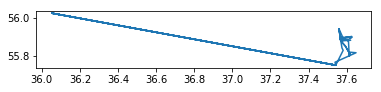

In [143]:
paths.loc[[2], 'geometry'].plot()

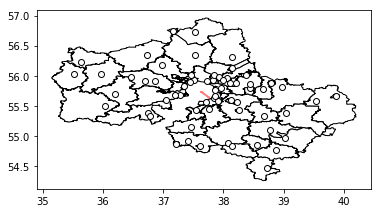

In [146]:
base = mos_ref.plot(color='white', edgecolor='black')

paths.loc[[8], 'geometry'].plot(ax=base, color='red', alpha = 0.5);

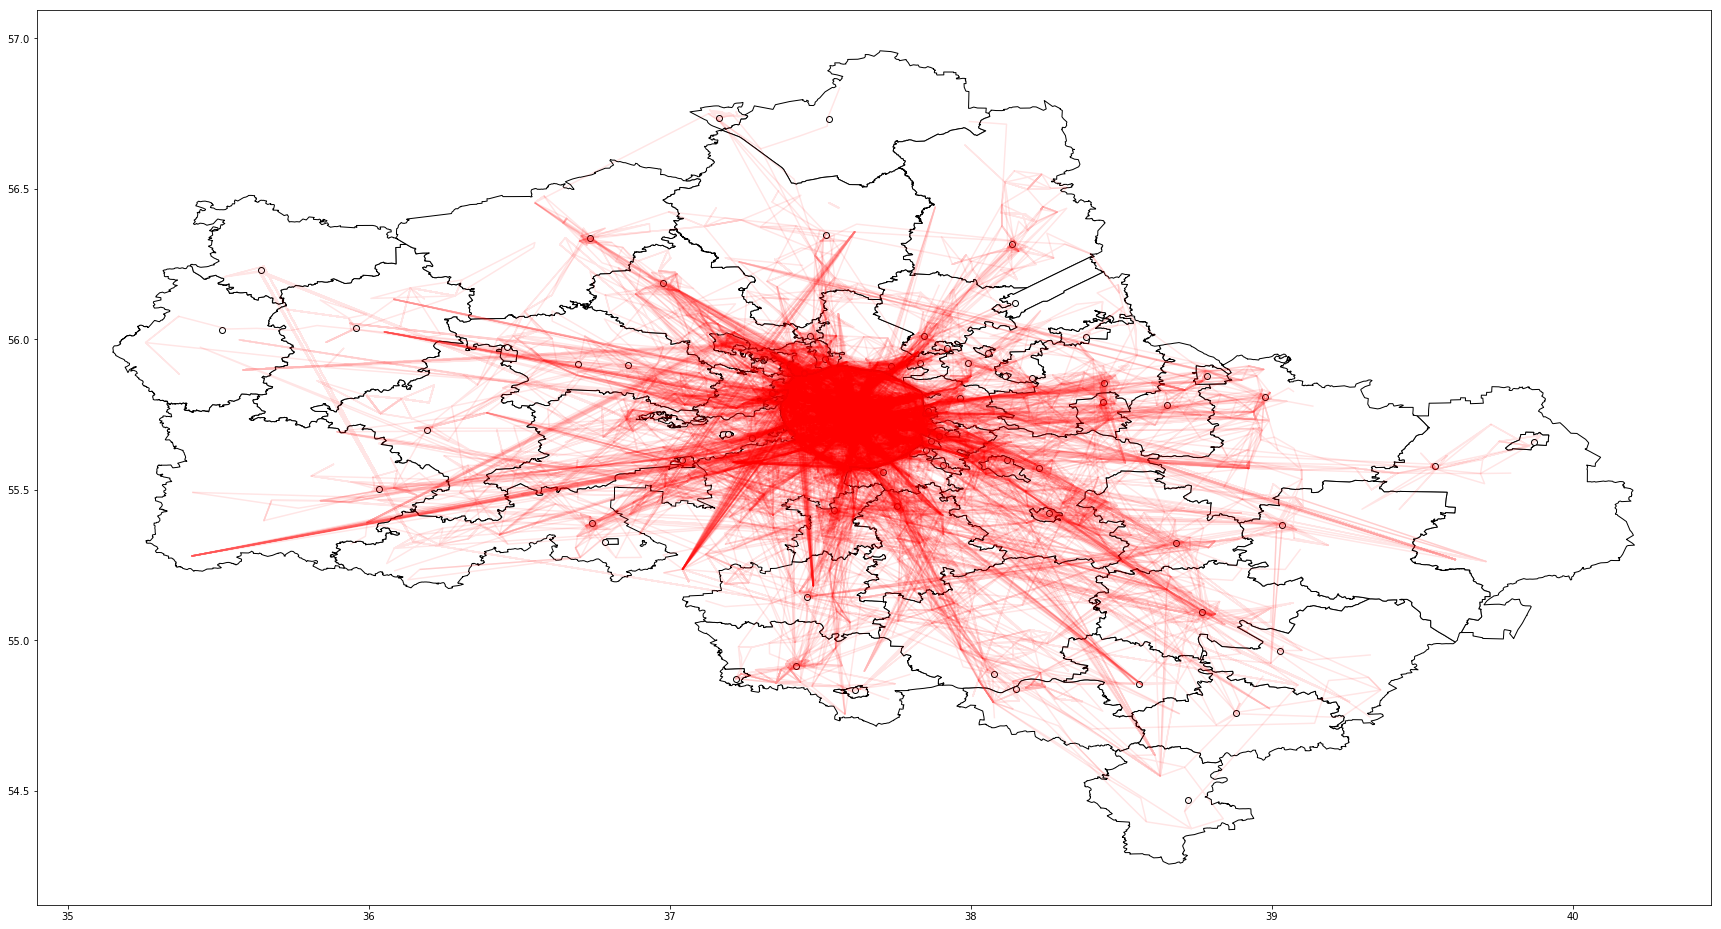

In [148]:
# fig = plt.figure(figsize = (20,20))
base = mos_ref.plot(figsize=(30,20),color='white', edgecolor='black')

paths.plot(figsize=(30,20),ax=base, color='red', alpha = 0.1);

Считаем попарные расстояния между линиями

In [23]:
#worked for 30 min
count_dist = []
for i in range(2330):
    for m in range(2330):#(paths.shape[0]):
        print(m)
        count_dist+=[[paths.id[i], paths.id[m], paths.geometry[i].distance(paths.geometry[m])]]

0


NameError: name 'paths' is not defined

In [189]:
count_dist

[[158500002513, 158500002513, 0.0],
 [158500002513, 158500006927, 0.6466969928526963],
 [158500002513, 158500010757, 0.6661673813689678],
 [158500002513, 158500013119, 0.48733361263100977],
 [158500002513, 158500019021, 0.2817449200961583],
 [158500002513, 158500020139, 0.8312740161944118],
 [158500002513, 158500039411, 0.764217959747079],
 [158500002513, 158500040851, 0.7149802794483027],
 [158500002513, 158500040977, 0.7767367185861671],
 [158500002513, 158500052757, 0.7655542828565355],
 [158500002513, 158500118785, 0.7829851084151952],
 [158500002513, 158500129117, 0.6755897571751693],
 [158500002513, 158500159523, 0.7440772607733621],
 [158500002513, 158500200323, 0.7563046395440994],
 [158500002513, 158500214435, 0.7497932048238292],
 [158500002513, 158500229107, 0.7180855102284185],
 [158500002513, 158500237627, 0.9976815733964971],
 [158500002513, 158500273073, 0.7486946306739285],
 [158500002513, 158500407957, 0.3314654883996165],
 [158500002513, 158500408895, 0.42999732557306

In [190]:
df_dist = pd.DataFrame(data = count_dist, columns=['id1','id2','distance'])

In [191]:
df_dist = df_dist[df_dist['id1'] != df_dist['id2']]

In [47]:
df_dist.shape

(5426570, 3)

In [193]:
df_dist.to_csv('dist_between_lines.csv')

In [19]:
df_dist = pd.read_csv('dist_between_lines.csv')

In [20]:
df_dist.drop(columns='Unnamed: 0', inplace = True)

In [27]:
df_dist.head()

,id1,id2,distance
0,158500002513,158500006927,0.646697
1,158500002513,158500010757,0.666167
2,158500002513,158500013119,0.487334
3,158500002513,158500019021,0.281745
4,158500002513,158500020139,0.831274


In [28]:
df_dist.groupby(['id1'])['distance'].min().value_counts()

0.000000    2318
0.020787       1
0.016389       1
0.018349       1
0.022275       1
0.028148       1
0.074723       1
0.006649       1
0.004625       1
0.000036       1
0.002860       1
0.002123       1
0.010729       1
Name: distance, dtype: int64

Видим, что минимальная дистанция между маршрутами в большинстве случаев равна 0. Возьмем любую пару из трейна и проверим расстояние между ними

In [49]:
df_dist[(df_dist.id1 == 158525444655) & (df_dist.id2 == 158599337515)]

,id1,id2,distance
2582849,158525444655,158599337515,0.020316


Хм, все оказалось неожиданнее, чем ожидалось. Проверим все пары

In [55]:
df_reverse.head()

,num_1,num_2
0,158530067653,158528861653
1,158510912201,158528852857
2,158530063945,158528861599
3,158524011325,158524011355
4,158528852153,158528861475


In [21]:
dist_check = []
for i in range(df_reverse.shape[0]):
    dist_check += [df_dist[(df_dist.id1 == df_reverse.num_1[i]) & (df_dist.id2 == df_reverse.num_2[i])].distance.values]

In [22]:
dist_train = pd.DataFrame(data = dist_check)

In [23]:
dist_train.fillna(-1, inplace = True)

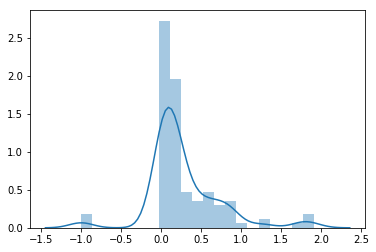

In [32]:
sns.distplot(dist_train)

In [33]:
np.percentile(dist_train, 80)

0.5279194067279673

Большая часть все-таки приходится на ноль. 80% наблюдений меньше 0.53, будем считать это отсечкой.

In [154]:
df_dist[(df_dist.id1 == df_reverse.num_1[243]) & (df_dist.id2 == df_reverse.num_2[243])]

,id1,id2,distance
2032941,158522532707,158538549041,0.803334


In [34]:
df_dist.shape, df_reverse.shape

((5426570, 3), (244, 2))

In [35]:
df_reverse.tail()


,num_1,num_2
239,158537959439,158535693543
240,158522944879,158521773577
241,158507587401,158503697375
242,158525734415,158598992329
243,158522532707,158538549041


In [36]:
dist_train.tail()

,0
239,0.163194
240,0.628618
241,0.527919
242,0.114067
243,0.803334


In [37]:
dist_train.shape, df_reverse.shape

((244, 1), (244, 2))

In [24]:
df_dist_train = pd.concat([df_reverse, dist_train], axis =1)

In [25]:
df_dist[df_dist.distance < 0.53].groupby(['id1','id2'])['id2'].count()

id1           id2         
158500002513  158500013119    1
              158500019021    1
              158500407957    1
              158500408895    1
              158500454525    1
              158500479921    1
              158500730487    1
              158500747347    1
              158500755409    1
              158500970361    1
              158500994795    1
              158501000083    1
              158501300583    1
              158501353023    1
              158501669217    1
              158501946167    1
              158502228459    1
              158502683611    1
              158502685299    1
              158502934945    1
              158503007309    1
              158503130511    1
              158503304103    1
              158503727271    1
              158503728727    1
              158503789889    1
              158503800973    1
              158503892947    1
              158504045501    1
              158504171213    1
             

Каждому номеру мы нашли соответствующие другие номера, чья траектория не отклоняется значительно изначального, и соответствий гораздо больше одного. Это можно объяснить таким случаями, как студенты, живущие в одном общежитии и ездящие на пары одним маршрутом.

Сгруппируем пары номеров, которые входят в персентиль, проставим 1 в поле конверсии, если это известная пара номеров, принадлежащая одному человеку.

In [26]:
df_dist_80 = df_dist[df_dist.distance < 0.53]


In [27]:
df_dist_80['conv'] = 0

/home/andrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
for i in range(df_reverse.shape[0]):
    df_dist_80.loc[df_dist_80[(df_dist_80.id1 == df_reverse.num_1[i]) & (df_dist_80.id2 == df_reverse.num_2[i])].index,'conv']= 1

/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
df_dist_80

,id1,id2,distance,conv
2,158500002513,158500013119,0.487334,0
3,158500002513,158500019021,0.281745,0
17,158500002513,158500407957,0.331465,0
18,158500002513,158500408895,0.429997,0
26,158500002513,158500454525,0.402621,0
30,158500002513,158500479921,0.526925,0
49,158500002513,158500730487,0.523333,0
50,158500002513,158500747347,0.438352,0
51,158500002513,158500755409,0.487334,0
65,158500002513,158500970361,0.384344,0


In [29]:
df_dist_80.conv.value_counts()

0    4451574
1        190
Name: conv, dtype: int64

In [192]:
df_dist_80[df_dist_80.conv == 1]

,id1,id2,distance,conv
47973,158500411793,158529027621,0.282816,1
110069,158500670731,158516086365,0.146233,1
114170,158500730293,158500730487,0.070333,1
116499,158500730487,158500730293,0.070333,1
149673,158500941403,158516497707,0.110106,1
242498,158501551109,158505222935,0.297146,1
247187,158501557263,158506092285,0.000000,1
323047,158502336809,158532486825,0.000000,1
366405,158502683611,158520842209,0.000000,1
385560,158502911917,158527501713,0.167477,1


### Хорды

Считаем хорды, так как нам известны градусы входа и выхода из зоны приему базовой станции, а также радиус передачи сигнала

In [30]:
#считаем что идет по прямой, но это не факт, в метрах
df_geo['chorde'] = 2*df_geo.max_dist*abs(np.sin(np.radians(abs(df_geo.end_angle - df_geo.start_angle))))

In [31]:
chorde = df_geo.groupby('msisdn')['chorde'].mean()

In [32]:
chorde = chorde.reset_index()

### время

Считаем, сколько времени занял весь путь

In [33]:
df_geo.date = pd.to_datetime(df_geo.date)

In [34]:
time_dif = df_geo.groupby('msisdn').date.max() - df_geo.groupby('msisdn').date.min()


In [35]:
time_dif = time_dif.reset_index()
time_dif.columns = ['msisdn', 'time_dif']

In [36]:
df_geo = df_geo.merge(time_dif, on = 'msisdn')

In [37]:
df_geo

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,...,tac,vendor,platform,type,num_1,num_2,geometry,date,chorde,time_dif
0,5082,43113,158500002513,3.573050e+14,5,1369276664822,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-23 06:37:44,4049.534788,1 days 22:48:56
1,5082,43113,158500002513,3.573050e+14,5,1369293994074,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-23 11:26:34,4049.534788,1 days 22:48:56
2,5082,43113,158500002513,3.573050e+14,5,1369356963156,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 04:56:03,4049.534788,1 days 22:48:56
3,5082,43113,158500002513,3.573050e+14,1,1369356982000,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 04:56:22,4049.534788,1 days 22:48:56
4,5082,43113,158500002513,3.573050e+14,5,1369404682777,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 18:11:22,4049.534788,1 days 22:48:56
5,5082,43114,158500002513,3.573050e+14,1,1369412364223,38.1339,56.3336,1754,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 20:19:24,3038.017116,1 days 22:48:56
6,5082,43113,158500002513,3.573050e+14,2,1369412379027,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 20:19:39,4049.534788,1 days 22:48:56
7,5082,43113,158500002513,3.573050e+14,5,1369445200225,38.1339,56.3336,2338,OUTDOOR,...,35730503,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-25 05:26:40,4049.534788,1 days 22:48:56
8,5082,41772,158500006927,3.548640e+14,1,1369256816362,37.5529,56.0115,3913,OUTDOOR,...,35486404,Nokia,Symbian OS,SmartPhone,NaN,NaN,POINT (37.5529 56.0115),2013-05-23 01:06:56,6777.514810,2 days 21:50:06
9,5031,41577,158500006927,3.548640e+14,0,1369257506972,37.4960,55.9440,1168,OUTDOOR,...,35486404,Nokia,Symbian OS,SmartPhone,NaN,NaN,POINT (37.496 55.944),2013-05-23 01:18:26,2023.035343,2 days 21:50:06


### скорость

Считаем среднюю скорость пути, м/с

In [38]:
df_geo['speed'] = df_geo['chorde']/ df_geo['time_dif'].apply(lambda x: x.total_seconds())

In [39]:
speed = df_geo.groupby('msisdn')['speed'].mean().reset_index()

In [40]:
#убираем бесконечности
speed = speed.replace([np.inf, -np.inf], np.nan).dropna(subset=['speed'], how="all")

In [41]:
speed.describe()

,msisdn,speed
count,2.330000e+03,2.330000e+03
mean,1.585293e+11,1.997892e-01
std,2.386150e+07,6.893986e+00
min,1.585000e+11,7.041583e-19
25%,1.585158e+11,6.237006e-03
50%,1.585265e+11,8.390215e-03
75%,1.585342e+11,1.131297e-02
max,1.586000e+11,3.265349e+02


### Трейн и тест

In [42]:
df_geo

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,...,vendor,platform,type,num_1,num_2,geometry,date,chorde,time_dif,speed
0,5082,43113,158500002513,3.573050e+14,5,1369276664822,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-23 06:37:44,4049.534788,1 days 22:48:56,0.024028
1,5082,43113,158500002513,3.573050e+14,5,1369293994074,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-23 11:26:34,4049.534788,1 days 22:48:56,0.024028
2,5082,43113,158500002513,3.573050e+14,5,1369356963156,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 04:56:03,4049.534788,1 days 22:48:56,0.024028
3,5082,43113,158500002513,3.573050e+14,1,1369356982000,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 04:56:22,4049.534788,1 days 22:48:56,0.024028
4,5082,43113,158500002513,3.573050e+14,5,1369404682777,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 18:11:22,4049.534788,1 days 22:48:56,0.024028
5,5082,43114,158500002513,3.573050e+14,1,1369412364223,38.1339,56.3336,1754,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 20:19:24,3038.017116,1 days 22:48:56,0.018026
6,5082,43113,158500002513,3.573050e+14,2,1369412379027,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-24 20:19:39,4049.534788,1 days 22:48:56,0.024028
7,5082,43113,158500002513,3.573050e+14,5,1369445200225,38.1339,56.3336,2338,OUTDOOR,...,Telit,Proprietary,Data card,NaN,NaN,POINT (38.1339 56.3336),2013-05-25 05:26:40,4049.534788,1 days 22:48:56,0.024028
8,5082,41772,158500006927,3.548640e+14,1,1369256816362,37.5529,56.0115,3913,OUTDOOR,...,Nokia,Symbian OS,SmartPhone,NaN,NaN,POINT (37.5529 56.0115),2013-05-23 01:06:56,6777.514810,2 days 21:50:06,0.026958
9,5031,41577,158500006927,3.548640e+14,0,1369257506972,37.4960,55.9440,1168,OUTDOOR,...,Nokia,Symbian OS,SmartPhone,NaN,NaN,POINT (37.496 55.944),2013-05-23 01:18:26,2023.035343,2 days 21:50:06,0.008047


In [43]:
df_geo[~df_geo.num_2.isna()].num_1 = df_geo[~df_geo.num_2.isna()].num_1.astype(int)
df_geo[~df_geo.num_2.isna()].num_2 = df_geo[~df_geo.num_2.isna()].num_2.astype(int)


/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [44]:
train = df_geo[~df_geo.num_2.isna()]

In [60]:
train.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,...,vendor,platform,type,num_1,num_2,geometry,date,chorde,time_dif,speed
1161,5020,24424,158500411793,3.543141e+14,0,1369319120208,38.4443,55.7843,1109,OUTDOOR,...,Samsung,Android,Laptop,1.585004e+11,1.585290e+11,POINT (38.4443 55.7843),2013-05-23 18:25:20,1920.844346,2 days 02:17:07,0.010611
1162,5020,5834,158500411793,3.543141e+14,0,1369319167662,38.4504,55.7702,50,OUTDOOR,...,Samsung,Android,Laptop,1.585004e+11,1.585290e+11,POINT (38.4504 55.7702),2013-05-23 18:26:07,86.602540,2 days 02:17:07,0.000478
1163,5020,41356,158500411793,3.543141e+14,0,1369319417739,38.4298,55.7798,1163,OUTDOOR,...,Samsung,Android,Laptop,1.585004e+11,1.585290e+11,POINT (38.4298 55.7798),2013-05-23 18:30:17,2014.375089,2 days 02:17:07,0.011127
1164,5020,49184,158500411793,3.543141e+14,0,1369320483478,38.4512,55.7864,505,OUTDOOR,...,Samsung,Android,Laptop,1.585004e+11,1.585290e+11,POINT (38.4512 55.7864),2013-05-23 18:48:03,874.685658,2 days 02:17:07,0.004832
1165,5020,49184,158500411793,3.543141e+14,0,1369321980816,38.4512,55.7864,505,OUTDOOR,...,Samsung,Android,Laptop,1.585004e+11,1.585290e+11,POINT (38.4512 55.7864),2013-05-23 19:13:00,874.685658,2 days 02:17:07,0.004832


In [45]:
train.num_1 = train.num_1.astype(int)
train.num_2 = train.num_2.astype(int)


/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Проверим пару наблюдений

In [109]:
train[(train.num_1 == 158599337515) | (train.num_1 == 158525444655)]

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,...,vendor,platform,type,num_1,num_2,geometry,date,chorde,time_dif,speed
76320,5019,58565,158525444655,3.529810e+14,0,1369324373195,37.4386,55.6334,50,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-23 19:52:53,86.602540,2 days 02:34:46,0.000476
76321,5019,58567,158525444655,3.529810e+14,5,1369330944958,37.4386,55.6334,1176,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-23 21:42:24,2036.891750,2 days 02:34:46,0.011186
76322,5019,58568,158525444655,3.529810e+14,5,1369353951167,37.4386,55.6334,1284,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-24 04:05:51,2223.953237,2 days 02:34:46,0.012214
76323,7711,58579,158525444655,3.529810e+14,0,1369367155785,37.4684,55.6193,1572,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4684 55.6193),2013-05-24 07:45:55,2722.783869,2 days 02:34:46,0.014953
76324,5019,58567,158525444655,3.529810e+14,5,1369424807736,37.4386,55.6334,1176,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-24 23:46:47,2036.891750,2 days 02:34:46,0.011186
76325,5019,58567,158525444655,3.529810e+14,5,1369447813567,37.4386,55.6334,1176,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-25 06:10:13,2036.891750,2 days 02:34:46,0.011186
76326,7711,33918,158525444655,3.529810e+14,5,1369469916657,37.4867,55.6190,1143,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4867 55.619),2013-05-25 12:18:36,1979.734073,2 days 02:34:46,0.010873
76327,5019,58568,158525444655,3.529810e+14,0,1369496253128,37.4386,55.6334,1284,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-25 19:37:33,2223.953237,2 days 02:34:46,0.012214
76328,7711,58579,158525444655,3.529810e+14,0,1369496411710,37.4684,55.6193,1572,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4684 55.6193),2013-05-25 19:40:11,2722.783869,2 days 02:34:46,0.014953
76329,5019,58567,158525444655,3.529810e+14,8,1369498244111,37.4386,55.6334,1176,OUTDOOR,...,Samsung,Proprietary,Phone,158525444655,158599337515,POINT (37.4386 55.6334),2013-05-25 20:10:44,2036.891750,2 days 02:34:46,0.011186


In [362]:
train[(train.num_1_y == 158599337515)].chorde.sum()

171973.59263270625

In [363]:
train[(train.num_1_y == 158525444655)].chorde.sum()

22144.269574768095

In [364]:
train[(train.num_1_y == 158599337515)].time_dif_y.head()

171213   2 days 12:58:17
171214   2 days 12:58:17
171215   2 days 12:58:17
171216   2 days 12:58:17
171217   2 days 12:58:17
Name: time_dif_y, dtype: timedelta64[ns]

In [365]:
train[(train.num_1_y == 158525444655)].time_dif_y.head()

76320   2 days 02:34:46
76321   2 days 02:34:46
76322   2 days 02:34:46
76323   2 days 02:34:46
76324   2 days 02:34:46
Name: time_dif_y, dtype: timedelta64[ns]

In [366]:
train[(train.num_1_y == 158599337515)].vendor.head()

171213    Samsung
171214    Samsung
171215    Samsung
171216    Samsung
171217    Samsung
Name: vendor, dtype: object

In [367]:
train[(train.num_1_y == 158525444655)].vendor.head()

76320    Samsung
76321    Samsung
76322    Samsung
76323    Samsung
76324    Samsung
Name: vendor, dtype: object

In [370]:
df_dist[(df_dist.id1 == 158525444655) & (df_dist.id2 == 158599337515)]

,id1,id2,distance
2583958,158525444655,158599337515,0.020316


In [391]:
train[(train.num_1_y == 158599337515)].speed.mean()

0.013508439486385736

In [390]:
train[(train.num_1_y == 158525444655)].speed.mean()

0.011055849521039557

Таким образом, у дублей:
 - Одинаковые телефоны, однако это не всегда правда. 
 - Неодинаковое пройденное расстояние, хотя разность относительно небольшая
 - Расстояние между их траекториями не ноль
 - Скорости похожи
 
 Сгруппируем все наши нагенерированные фичи в один датафрейм с выбранной отсечкой по дистанции

In [46]:
df_dist_train

,num_1,num_2,0
0,158530067653,158528861653,0.000000
1,158510912201,158528852857,-1.000000
2,158530063945,158528861599,0.000000
3,158524011325,158524011355,0.526181
4,158528852153,158528861475,0.170437
5,158510912383,158524011019,0.639599
6,158503851673,158528849161,0.227312
7,158524011011,158528850813,0.364090
8,158524011043,158528850739,1.284991
9,158524002695,158515581635,0.244901


In [135]:
df_geo.msisdn.unique().shape

(2361,)

In [134]:
train.msisdn.unique().shape

(241,)

In [47]:
tel = df_geo.groupby(['msisdn','vendor'])['vendor'].nunique().rename(columns = {'vendor':'count'}).reset_index()

In [171]:
df_dist_train

,num_1,num_2,0
0,158530067653,158528861653,0.000000
1,158510912201,158528852857,-1.000000
2,158530063945,158528861599,0.000000
3,158524011325,158524011355,0.526181
4,158528852153,158528861475,0.170437
5,158510912383,158524011019,0.639599
6,158503851673,158528849161,0.227312
7,158524011011,158528850813,0.364090
8,158524011043,158528850739,1.284991
9,158524002695,158515581635,0.244901


In [86]:
df_dist_80

,id1,id2,distance,conv
2,158500002513,158500013119,0.487334,0
3,158500002513,158500019021,0.281745,0
17,158500002513,158500407957,0.331465,0
18,158500002513,158500408895,0.429997,0
26,158500002513,158500454525,0.402621,0
30,158500002513,158500479921,0.526925,0
49,158500002513,158500730487,0.523333,0
50,158500002513,158500747347,0.438352,0
51,158500002513,158500755409,0.487334,0
65,158500002513,158500970361,0.384344,0


In [199]:
chorde


,msisdn,chorde
0,158500002513,3923.095079
1,158500006927,1982.223222
2,158500010757,1424.589583
3,158500013119,1378.570674
4,158500019021,2204.467665
5,158500020139,2941.888297
6,158500039411,1010.635709
7,158500040851,1372.262514
8,158500040977,914.378370
9,158500052757,1308.684963


In [48]:
all_features2 = chorde.merge(speed, on = 'msisdn', how = 'outer').merge(time_dif, on = 'msisdn', how = 'outer')\
.merge(df_dist_80, how = 'right', left_on = 'msisdn', right_on = 'id1')\
.merge(tel[['msisdn', 'vendor']], on = 'msisdn', how = 'outer')

Вытаскиваем наши фичи из попарных соответствий наблюдений трейна

In [49]:
check_double = []
for i in range(df_reverse.shape[0]):
    try:
        a = all_features2[(all_features2.id1 == df_reverse.num_1[i]) & (all_features2.id2 == df_reverse.num_2[i])]
        b = all_features2[(all_features2.id2 == df_reverse.num_1[i]) & (all_features2.id1 == df_reverse.num_2[i])]
        c = pd.concat([b,a], ignore_index=True)
        print(i)

        check_double += [pd.concat([c[['id1','id2']].iloc[0],c.groupby(['distance'])['chorde', 'speed', 'time_dif'].diff().iloc[1]]).values]
    except IndexError:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243


In [50]:
stat = pd.DataFrame(data = check_double, columns= ['id1', 'id2', 'chorde', 'speed', 'time_dif'])

In [51]:
stat.describe()

,id1,id2,chorde,speed,time_dif
count,1.900000e+02,1.900000e+02,190.000000,1.840000e+02,190
mean,1.585266e+11,1.585266e+11,11.996965,3.028261e-05,0 days 00:09:40.984210
std,2.085142e+07,2.085142e+07,828.790458,1.137708e+00,1 days 00:50:33.039934
min,1.585004e+11,1.585004e+11,-3045.330220,-9.316163e+00,-3 days +00:33:31
25%,1.585157e+11,1.585157e+11,-280.216534,-2.662478e-03,-1 days +13:22:23.750000
50%,1.585254e+11,1.585254e+11,1.677192,8.578187e-07,0 days 00:03:04
75%,1.585305e+11,1.585305e+11,291.596133,2.706420e-03,0 days 10:43:06.750000
max,1.585996e+11,1.585996e+11,3045.330220,9.316163e+00,2 days 23:26:29


Можно выделить эвристики на основе таблички выше

In [52]:
min_chorde = stat.chorde.min()
max_chorde = stat.chorde.max()
min_speed = stat.speed.min()
max_speed = stat.speed.max()
min_time = stat.time_dif.min()
max_time = stat.time_dif.max()

In [53]:
all_features2.describe()

,msisdn,chorde,speed,time_dif,id1,id2,distance,conv
count,4.630386e+06,4.630352e+06,4.572626e+06,4630352,4.630352e+06,4.630352e+06,4.630352e+06,4.630352e+06
mean,1.585283e+11,1.991543e+03,2.105520e-01,2 days 09:56:33.277491,1.585283e+11,1.585284e+11,1.310567e-01,4.124956e-05
std,2.251580e+07,1.047197e+03,7.112466e+00,0 days 15:08:55.587414,2.251505e+07,2.251420e+07,1.443218e-01,6.422451e-03
min,1.585000e+11,1.239343e-13,7.041583e-19,0 days 00:00:00,1.585000e+11,1.585000e+11,0.000000e+00,0.000000e+00
25%,1.585157e+11,1.379600e+03,6.240892e-03,2 days 07:24:25,1.585157e+11,1.585157e+11,0.000000e+00,0.000000e+00
50%,1.585263e+11,1.853841e+03,8.387550e-03,2 days 14:08:02,1.585263e+11,1.585264e+11,8.067392e-02,0.000000e+00
75%,1.585339e+11,2.237983e+03,1.120517e-02,2 days 20:28:11,1.585339e+11,1.585340e+11,2.195238e-01,0.000000e+00
max,1.586000e+11,1.414722e+04,3.265349e+02,2 days 23:59:17,1.585996e+11,1.585996e+11,5.299974e-01,1.000000e+00


In [98]:
all_features2.tail()

,msisdn,chorde,speed,time_dif,id1,id2,distance,conv,vendor
4630347,158599612203,1753.347715,0.006841,2 days 23:11:55.000000000,1.585996e+11,1.585995e+11,0.006886,0.0,Apple
4630348,158599612203,1753.347715,0.006841,2 days 23:11:55.000000000,1.585996e+11,1.585995e+11,0.196255,0.0,Apple
4630349,158599612203,1753.347715,0.006841,2 days 23:11:55.000000000,1.585996e+11,1.585996e+11,0.028066,0.0,Apple
4630350,158599612203,1753.347715,0.006841,2 days 23:11:55.000000000,1.585996e+11,1.585996e+11,0.019626,0.0,Apple
4630351,158599612203,1753.347715,0.006841,2 days 23:11:55.000000000,1.585996e+11,1.585996e+11,0.058036,0.0,Apple


In [93]:
all_features2[all_features2.conv == 1]

,msisdn,chorde,speed,time_dif,id1,id2,distance,conv,vendor
48655,158500411793,1593.400140,0.008802,2 days 02:17:07,1.585004e+11,1.585290e+11,0.282816,1.0,Samsung
94842,158500670731,3197.365791,5.629165,0 days 00:09:28,1.585007e+11,1.585161e+11,0.146233,1.0,Apple
98525,158500730293,1912.227101,0.008388,2 days 15:19:44,1.585007e+11,1.585007e+11,0.070333,1.0,Nokia
100656,158500730487,1111.585743,0.005049,2 days 13:09:40,1.585007e+11,1.585007e+11,0.070333,1.0,Apple
131921,158500941403,1912.299562,0.008172,2 days 16:59:56,1.585009e+11,1.585165e+11,0.110106,1.0,Samsung
209980,158501551109,1731.868486,0.006758,2 days 23:11:03,1.585016e+11,1.585052e+11,0.297146,1.0,Apple
214058,158501557263,1847.504032,0.007753,2 days 18:11:24,1.585016e+11,1.585061e+11,0.000000,1.0,Nokia
276456,158502336809,2606.159115,0.010231,2 days 22:45:41,1.585023e+11,1.585325e+11,0.000000,1.0,Nokia
313786,158502683611,2094.181643,0.018991,1 days 06:37:54,1.585027e+11,1.585208e+11,0.000000,1.0,NaN
330543,158502911917,1854.902697,0.008179,2 days 14:59:40,1.585029e+11,1.585275e+11,0.167477,1.0,Nokia


In [49]:
all_features2.to_csv('all_features.csv', index = None)

In [94]:
all_features2 = pd.read_csv('all_features.csv')

### Models

In [54]:
all_features2.dropna(subset = ['chorde'], inplace = True)

In [56]:
all_features2.shape, all_features2.chorde.dropna().shape

((4630352, 9), (4630352,))

In [115]:
all_features2.head()

,msisdn,chorde,speed,time_dif,id1,id2,distance,conv,vendor
0,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585000e+11,0.487334,0.0,Telit
1,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585000e+11,0.281745,0.0,Telit
2,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585004e+11,0.331465,0.0,Telit
3,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585004e+11,0.429997,0.0,Telit
4,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585005e+11,0.402621,0.0,Telit


Выделим выборку номеров, которые уже размечены. Прогоним на ней дерево

In [57]:
train = all_features2[all_features2.msisdn.isin(df_reverse.num_1.values)]

In [58]:
train.dropna(inplace = True)

/home/andrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
num_x = train[['chorde','speed','time_dif', 'distance']]
y = train['conv']
cat_x = pd.get_dummies(train.vendor)
X = pd.concat([num_x, cat_x], axis = 1)

In [123]:
X.time_dif = pd.to_timedelta(X.time_dif)

In [124]:
X.time_dif = X.time_dif.apply(lambda x: x.total_seconds() / 60)

In [125]:
num_x.shape, cat_x.shape, X.shape, y.shape

((421618, 4), (421618, 21), (421618, 25), (421618,))

In [126]:
num_x.tail()

,chorde,speed,time_dif,distance
4628179,2088.071057,0.009795,2 days 11:13:08,0.020412
4628180,2088.071057,0.009795,2 days 11:13:08,0.259149
4628181,2088.071057,0.009795,2 days 11:13:08,0.000000
4628182,2088.071057,0.009795,2 days 11:13:08,0.191000
4628183,2088.071057,0.009795,2 days 11:13:08,0.058036


In [204]:
X.to_csv('train_meg.csv', index = False)

In [149]:
X = pd.read_csv('train_meg.csv')

In [150]:
X

,chorde,speed,time_dif,distance,Alcatel,Apple,Blackberry,Changjiang,Explay,Fly,...,LG,Nokia,Nony,Sagetel,Samsung,Samsung,Sierra,Sony,Sony Ericsson,Umeox
0,1593.400140,0.008802,3017.116667,0.000000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1593.400140,0.008802,3017.116667,0.512361,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1593.400140,0.008802,3017.116667,0.460724,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1593.400140,0.008802,3017.116667,0.229880,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1593.400140,0.008802,3017.116667,0.374172,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1593.400140,0.008802,3017.116667,0.378267,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1593.400140,0.008802,3017.116667,0.489673,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,1593.400140,0.008802,3017.116667,0.453292,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,1593.400140,0.008802,3017.116667,0.396425,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1593.400140,0.008802,3017.116667,0.508986,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [134]:
num_x.time_dif = num_x.time_dif.apply(lambda x: x.total_seconds() / 60)

/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [59]:
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score

/home/andrey/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
# clf = LogisticRegression(random_state=0)


In [127]:
X.dropna(inplace = True)

In [128]:
X = X.reset_index(drop = True)

In [141]:
num_x = num_x.replace([np.inf, -np.inf], np.nan)

In [142]:
num_x = num_x.reset_index(drop=True)

In [144]:
num_x

,chorde,speed,time_dif,distance
0,1593.400140,0.008802,3017.116667,0.000000
1,1593.400140,0.008802,3017.116667,0.512361
2,1593.400140,0.008802,3017.116667,0.460724
3,1593.400140,0.008802,3017.116667,0.229880
4,1593.400140,0.008802,3017.116667,0.374172
5,1593.400140,0.008802,3017.116667,0.378267
6,1593.400140,0.008802,3017.116667,0.489673
7,1593.400140,0.008802,3017.116667,0.453292
8,1593.400140,0.008802,3017.116667,0.396425
9,1593.400140,0.008802,3017.116667,0.508986


In [209]:
X.describe()

,chorde,speed,time_dif,distance,Alcatel,Apple,Blackberry,Changjiang,Explay,Fly,...,LG,Nokia,Nony,Sagetel,Samsung,Samsung,Sierra,Sony,Sony Ericsson,Umeox
count,4.505330e+05,4.440200e+05,450533.000000,450533.000000,450534.000000,450534.000000,450534.000000,450534.00000,450534.000000,450534.000000,...,450534.000000,450534.000000,450534.000000,450534.000000,450534.000000,450534.000000,450534.000000,450534.000000,450534.000000,450534.000000
mean,2.040910e+03,8.457746e-02,3137.758232,0.130130,0.019777,0.196121,0.005047,0.00477,0.018802,0.023474,...,0.023938,0.261128,0.003625,0.004914,0.258804,0.000604,0.000260,0.004592,0.023865,0.004490
std,1.027031e+03,7.509458e-01,1032.477056,0.143633,0.139232,0.397061,0.070865,0.06890,0.135826,0.151405,...,0.152857,0.439250,0.060095,0.069929,0.437978,0.024563,0.016113,0.067611,0.152629,0.066859
min,1.239343e-13,2.478685e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.379144e+03,6.950902e-03,2877.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.912300e+03,9.160978e-03,3550.250000,0.079665,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.361991e+03,1.332115e-02,3782.950000,0.216961,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.530735e+03,9.321278e+00,4309.983333,0.529993,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [132]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [133]:
accuracy_score(y_test, pred)

0.9993833309615293

У нас получилась высокая точность за счет переобучения дерева. Посмотрим, какие признаки наиболее важные, нарисуем само дерево

In [134]:
clf.feature_importances_

array([7.79827638e-03, 1.79183476e-02, 1.75351911e-02, 9.43135222e-01,
       2.42587753e-04, 9.32991424e-05, 5.54063037e-05, 0.00000000e+00,
       2.73228901e-05, 3.81678118e-05, 0.00000000e+00, 0.00000000e+00,
       1.92319918e-04, 0.00000000e+00, 2.55318631e-05, 3.53130932e-05,
       4.53058889e-05, 0.00000000e+00, 0.00000000e+00, 4.24464415e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.61306455e-03,
       0.00000000e+00])

In [135]:
import io

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_graphviz
from sklearn.feature_selection import mutual_info_classif

feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

out = io.StringIO()
out = export_graphviz(clf, out_file='tree.dot', max_depth=3)

feat importance = [3.81448945e-06 8.76467367e-06 8.57725454e-06 4.61330065e-04
 1.18660635e-07 4.56368275e-08 2.71017274e-08 0.00000000e+00
 1.33648605e-08 1.86696019e-08 0.00000000e+00 0.00000000e+00
 9.40723646e-08 0.00000000e+00 1.24887882e-08 1.72732300e-08
 2.21611580e-08 0.00000000e+00 0.00000000e+00 2.07624730e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.21303917e-06
 0.00000000e+00]


In [2]:
# !pip install StringIO

In [136]:
from graphviz import Source
path = 'tree.dot'
s = Source.from_file(path)
s.view()

'tree.dot.pdf'

In [3]:
# !pip install graphviz

Попробуем прогнать на всем датафрейме. Возьмем только числовые данные, иначе не хватает памяти

In [61]:
num_x = all_features2[['chorde','speed','time_dif', 'distance']]
y = all_features2['conv']
cat_x = pd.get_dummies(all_features2.vendor)

X = pd.concat([num_x, cat_x], axis = 1)
X = X.reset_index(drop = True)

In [62]:
X.time_dif = pd.to_timedelta(X.time_dif)

X.time_dif = X.time_dif.apply(lambda x: x.total_seconds() / 60)

In [63]:
num_x.time_dif = pd.to_timedelta(num_x.time_dif)
num_x.time_dif = num_x.time_dif.apply(lambda x: x.total_seconds() / 60)

/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [64]:
num_x.describe()

,chorde,speed,time_dif,distance
count,4.630352e+06,4.572626e+06,4.630352e+06,4.630352e+06
mean,1.991543e+03,2.105520e-01,3.476555e+03,1.310567e-01
std,1.047197e+03,7.112466e+00,9.089265e+02,1.443218e-01
min,1.239343e-13,7.041583e-19,0.000000e+00,0.000000e+00
25%,1.379600e+03,6.240892e-03,3.324417e+03,0.000000e+00
50%,1.853841e+03,8.387550e-03,3.728033e+03,8.067392e-02
75%,2.237983e+03,1.120517e-02,4.108183e+03,2.195238e-01
max,1.414722e+04,3.265349e+02,4.319283e+03,5.299974e-01


In [65]:
train2 = pd.concat([num_x, y], axis = 1).dropna()

In [66]:
train2.shape

(4572626, 5)

In [67]:
num_x = train2[['chorde','speed','time_dif', 'distance']]
y = train2['conv']


In [75]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(num_x, y, test_size=0.2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

accuracy_score(y_test, pred)

0.9999420464809092

In [76]:
pred = pd.Series(pred)
pred.value_counts()

0.0    914510
1.0        16
dtype: int64

Получили 16 потенциальных дубляжей номеров, цифра меняется, несмотря на зафиксированные сиды. 16 маловато для такого количества номеров, но рассмотрим идею подхода на этих цифрах

In [77]:
potential = all_features2.iloc[pred[pred == 1].index]

In [78]:
potential.id1.unique()

array([1.58501037e+11, 1.58502940e+11, 1.58503548e+11, 1.58503548e+11,
       1.58503622e+11, 1.58503878e+11, 1.58504168e+11, 1.58504423e+11,
       1.58505408e+11, 1.58506838e+11, 1.58507678e+11, 1.58507772e+11,
       1.58508824e+11, 1.58508835e+11, 1.58509099e+11])

Выберем по каждому предсказанному номеру номера, которые на наименьшем удалении

In [79]:
all_features2.head()

,msisdn,chorde,speed,time_dif,id1,id2,distance,conv,vendor
0,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585000e+11,0.487334,0.0,Telit
1,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585000e+11,0.281745,0.0,Telit
2,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585004e+11,0.331465,0.0,Telit
3,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585004e+11,0.429997,0.0,Telit
4,158500002513,3923.095079,0.023277,1 days 22:48:56,1.585000e+11,1.585005e+11,0.402621,0.0,Telit


Применим наши эвристики

In [80]:
df_potent = all_features2[(all_features2.msisdn.isin(potential.id1.unique()))&
             (all_features2.chorde > min_chorde) &
             (all_features2.chorde < max_chorde)&
             (all_features2.speed > min_speed)&
             (all_features2.speed < max_speed)&
             (all_features2.time_dif > min_time)&
             (all_features2.time_dif < max_time)]

In [81]:
df_potent.id1 = df_potent.id1.astype(int)
df_potent.id2 = df_potent.id2.astype(int)


/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [82]:
df_potent.head()

,msisdn,chorde,speed,time_dif,id1,id2,distance,conv,vendor
145784,158501037171,1794.404637,0.007985,2 days 14:25:30,158501037171,158500006927,0.000000,0.0,Samsung
145785,158501037171,1794.404637,0.007985,2 days 14:25:30,158501037171,158500010757,0.054187,0.0,Samsung
145786,158501037171,1794.404637,0.007985,2 days 14:25:30,158501037171,158500013119,0.030794,0.0,Samsung
145787,158501037171,1794.404637,0.007985,2 days 14:25:30,158501037171,158500019021,0.134544,0.0,Samsung
145788,158501037171,1794.404637,0.007985,2 days 14:25:30,158501037171,158500020139,0.171257,0.0,Samsung


In [83]:
df_potent.groupby(['id1'])['id2'].nunique()

id1
158501037171    2070
158502939865    2042
158503547703    2001
158503548069    2126
158503622363    2073
158503878307    2068
158504167577    1818
158505407647    1940
158506838305    2109
158507677819    2063
158507772285    2096
158508824461    2221
158508834995    2107
Name: id2, dtype: int64

Много, в первую очередь стоит проверить номера с минимальной дистанцией

In [84]:
df_potent[df_potent.distance==0].groupby(['id1'])['id2'].nunique()

id1
158501037171     141
158502939865     223
158503547703     121
158503548069     919
158503622363     347
158503878307     197
158504167577      86
158505407647      63
158506838305    1066
158507677819      80
158507772285     778
158508824461    1230
158508834995     792
Name: id2, dtype: int64

In [85]:
df_potent.groupby(['id1'])['distance'].agg(['min','max'])

,min,max
id1,,
158501037171,0.0,0.529428
158502939865,0.0,0.527368
158503547703,0.0,0.527097
158503548069,0.0,0.529350
158503622363,0.0,0.528470
158503878307,0.0,0.529247
158504167577,0.0,0.529287
158505407647,0.0,0.528896
158506838305,0.0,0.525309


In [98]:
def agg_f(x):
     return pd.Series(dict(Sequence = "%s" %  ",".join("'{0}'".format(n) for n in x['id2'])))


In [99]:
df_potent_list = df_potent[df_potent.distance==0].groupby(['id1']).apply(agg_f)

In [105]:
df_potent_list

,potential connection
id1,
158501037171,"'158500006927','158500996007','158501310415','..."
158502939865,"'158500013119','158500040851','158500755409','..."
158503547703,"'158500214435','158500407957','158500605647','..."
158503548069,"'158500006927','158500010757','158500013119','..."
158503622363,"'158500006927','158500006927','158500052757','..."
158503878307,"'158500040851','158500407957','158500428729','..."
158504167577,"'158500237627','158500526891','158500612893','..."
158505407647,"'158502020297','158502870115','158503506547','..."
158506838305,"'158500006927','158500010757','158500013119','..."


In [104]:
df_potent_list.columns= ['potential connection']

In [106]:
df_potent_list.to_csv('persona_numbers.csv')

Можно, в первую очередь, проверить нулевые варианты, потом расширить выбор за счет эвристик, по этим 16 номерам

**Пути улучшения:**

- дерево предсказало не так много подозрительных номеров, как хотелось бы, можно применять более изощренные алгоритмы
- на имеющихся данных не удалось вытащить много значимых признаков, которые бы точно детерминировали наличие второй симки. Изначальные гипотезы по расстоянию между маршрутами, одинаковыми скоростями и дистанциями не подтвердились. Нужно больше нормальных признаков
